# Aadhar Enrollment Analysis 

### Importing Libraries 

In [1]:
import pandas as pd 
import warnings
import matplotlib.pyplot as plt
import seaborn as sns 

## Loading Dataset

In [2]:
file_1 = pd.read_csv('api_data_aadhar_enrolment_0_500000.csv')
file_2 = pd.read_csv('api_data_aadhar_enrolment_500000_1000000.csv')
file_3 = pd.read_csv('api_data_aadhar_enrolment_1000000_1006029.csv')

In [3]:

print(file_1.columns.equals(file_2.columns))
print(file_2.columns.equals(file_3.columns))


True
True


In [4]:
# identifying mis-matches
set(file_1.columns) ^ set(file_2.columns)


set()

In [5]:
# concatenate the csv's
aadhar_raw = pd.concat(
    [file_1, file_2, file_3],
    axis=0,
    ignore_index=True
)


In [6]:
aadhar_raw.shape

(1006029, 7)

### Note:
The Aadhaar enrolment dataset was provided in multiple file partitions due to size constraints. All files were loaded using a consistent schema and concatenated vertically to reconstruct the complete dataset for analysis.

## Data Cleaning & Preprocessing

In [7]:
aadhar_raw['state'].unique()

array(['Meghalaya', 'Karnataka', 'Uttar Pradesh', 'Bihar', 'Maharashtra',
       'Haryana', 'Rajasthan', 'Punjab', 'Delhi', 'Madhya Pradesh',
       'West Bengal', 'Assam', 'Uttarakhand', 'Gujarat', 'Andhra Pradesh',
       'Tamil Nadu', 'Chhattisgarh', 'Jharkhand', 'Nagaland', 'Manipur',
       'Telangana', 'Tripura', 'Mizoram', 'Jammu and Kashmir',
       'Chandigarh', 'Sikkim', 'Odisha', 'Kerala',
       'The Dadra And Nagar Haveli And Daman And Diu',
       'Arunachal Pradesh', 'Himachal Pradesh', 'Goa',
       'Jammu And Kashmir', 'Dadra and Nagar Haveli and Daman and Diu',
       'Ladakh', 'Andaman and Nicobar Islands', 'Orissa', 'Pondicherry',
       'Puducherry', 'Lakshadweep', 'Andaman & Nicobar Islands',
       'Dadra & Nagar Haveli', 'Dadra and Nagar Haveli', 'Daman and Diu',
       'WEST BENGAL', 'Jammu & Kashmir', 'West  Bengal', '100000',
       'Daman & Diu', 'West Bangal', 'Westbengal', 'West bengal',
       'andhra pradesh', 'ODISHA', 'WESTBENGAL'], dtype=object)

In [8]:
aadhar_raw.loc[aadhar_raw['state']== '100000']

,date,state,district,pincode,age_0_5,age_5_17,age_18_greater
23108,02-09-2025,100000,100000,100000,0,0,3
46946,03-09-2025,100000,100000,100000,0,0,1
97816,08-09-2025,100000,100000,100000,0,0,1
115798,09-09-2025,100000,100000,100000,0,0,1
153156,11-09-2025,100000,100000,100000,0,0,2
160195,12-09-2025,100000,100000,100000,0,0,2
261778,19-09-2025,100000,100000,100000,0,0,1
272731,20-09-2025,100000,100000,100000,0,0,1
470934,24-10-2025,100000,100000,100000,0,1,0
762744,15-11-2025,100000,100000,100000,0,0,3


In [9]:
aadhar_raw = aadhar_raw[aadhar_raw['state'] != '100000']


In [10]:
aadhar_raw.loc[aadhar_raw['state']== '100000']

,date,state,district,pincode,age_0_5,age_5_17,age_18_greater


In [11]:
df_copy = aadhar_raw.copy()

In [12]:
df_copy['state']= (
    df_copy['state']
    .astype(str)
    .str.strip()
    .str.lower()
    .str.replace('&', 'and', regex=False)
    .str.replace(r'\s+', ' ', regex=True)
)

In [13]:
df_copy['state'].unique()

array(['meghalaya', 'karnataka', 'uttar pradesh', 'bihar', 'maharashtra',
       'haryana', 'rajasthan', 'punjab', 'delhi', 'madhya pradesh',
       'west bengal', 'assam', 'uttarakhand', 'gujarat', 'andhra pradesh',
       'tamil nadu', 'chhattisgarh', 'jharkhand', 'nagaland', 'manipur',
       'telangana', 'tripura', 'mizoram', 'jammu and kashmir',
       'chandigarh', 'sikkim', 'odisha', 'kerala',
       'the dadra and nagar haveli and daman and diu',
       'arunachal pradesh', 'himachal pradesh', 'goa',
       'dadra and nagar haveli and daman and diu', 'ladakh',
       'andaman and nicobar islands', 'orissa', 'pondicherry',
       'puducherry', 'lakshadweep', 'dadra and nagar haveli',
       'daman and diu', 'west bangal', 'westbengal'], dtype=object)

In [14]:
state_mapping = {
    
    'west bengal': 'West Bengal',
    'west bangal': 'West Bengal',
    'westbengal': 'West Bengal',

    
    'orissa': 'Odisha',
    'odisha': 'Odisha',

    
    'pondicherry': 'Puducherry',
    'puducherry': 'Puducherry',

    
    'jammu and kashmir': 'Jammu and Kashmir',
    'jammu and kashmir ': 'Jammu and Kashmir',
    'jammu and kashmir': 'Jammu and Kashmir',

    
    'dadra and nagar haveli': 'Dadra and Nagar Haveli and Daman and Diu',
    'daman and diu': 'Dadra and Nagar Haveli and Daman and Diu',
    'dadra and nagar haveli and daman and diu':
        'Dadra and Nagar Haveli and Daman and Diu',

    
    'andaman and nicobar islands': 'Andaman and Nicobar Islands',

    
    'andhra pradesh': 'Andhra Pradesh'
}


In [15]:
df_copy['state'] = df_copy['state'].map(state_mapping).fillna(df_copy['state'].str.title())
sorted(df_copy['state'].unique())

['Andaman and Nicobar Islands',
 'Andhra Pradesh',
 'Arunachal Pradesh',
 'Assam',
 'Bihar',
 'Chandigarh',
 'Chhattisgarh',
 'Dadra and Nagar Haveli and Daman and Diu',
 'Delhi',
 'Goa',
 'Gujarat',
 'Haryana',
 'Himachal Pradesh',
 'Jammu and Kashmir',
 'Jharkhand',
 'Karnataka',
 'Kerala',
 'Ladakh',
 'Lakshadweep',
 'Madhya Pradesh',
 'Maharashtra',
 'Manipur',
 'Meghalaya',
 'Mizoram',
 'Nagaland',
 'Odisha',
 'Puducherry',
 'Punjab',
 'Rajasthan',
 'Sikkim',
 'Tamil Nadu',
 'Telangana',
 'The Dadra And Nagar Haveli And Daman And Diu',
 'Tripura',
 'Uttar Pradesh',
 'Uttarakhand',
 'West Bengal']

In [16]:
df= df_copy

In [17]:
df['district'].unique()

array(['East Khasi Hills', 'Bengaluru Urban', 'Kanpur Nagar', 'Aligarh',
       'Sitamarhi', 'Bahraich', 'Firozabad', 'Purbi Champaran',
       'Maharajganj', 'Aurangabad', 'Ghaziabad', 'Faridabad', 'Madhubani',
       'Sikar', 'Bhagalpur', 'Amritsar', 'Gurugram',
       'Gautam Buddha Nagar', 'West Delhi', 'Bhind', 'Gwalior', 'Katni',
       'Coochbehar', 'Lucknow', 'Dinajpur Uttar', 'Marigaon', 'Kokrajhar',
       'Agra', 'Haridwar', 'Nagaon', 'Parbhani', 'West Khasi Hills',
       'North West Delhi', 'West Jaintia Hills', 'Unnao', 'Saharanpur',
       'Dibrugarh', 'Udalguri', 'Chirang', 'Kamrup', 'Dhubri', 'Jaunpur',
       'Thane', 'Dhemaji', 'Banas Kantha', 'Tinsukia', 'Spsr Nellore',
       'Barpeta', 'Sonitpur', 'Baksa', 'Ludhiana', 'Patan', 'Kanchipuram',
       'Patna', 'Lakhimpur', 'Bongaigaon', 'Vadodara', 'Nainital',
       'Dehradun', 'Hojai', 'Dohad', 'Morbi', 'Raipur', 'Gorakhpur',
       'Bulandshahr', 'Mathura', 'Pashchim Champaran', 'Bijapur',
       'Deoghar', 'Muzaf

In [18]:
df['district'] = (
    df['district']
    .astype(str)
    .str.strip()
    .str.lower()
    .str.replace('&', 'and', regex=False)
    .str.replace(r'\*', '', regex=True)
    .str.replace(r'\(.*?\)', '', regex=True)
    .str.replace(r'\s+', ' ', regex=True)
    .str.strip()
)


In [19]:
district_mapping = {

    # Andhra Pradesh / Telangana
    'cuddapah': 'Kadapa',
    'ysr': 'Kadapa',
    'y. s. r': 'Kadapa',
    'ysr kadapa': 'Kadapa',
    'visakhapatanam': 'Visakhapatnam',
    'spsr nellore': 'Sri Potti Sriramulu Nellore',
    'ananthapur': 'Anantapur',
    'ananthapuramu': 'Anantapur',
    'mahabub nagar': 'Mahabubnagar',
    'mahbubnagar': 'Mahabubnagar',
    'medchal malkajgiri': 'Medchal-Malkajgiri',
    'medchal?malkajgiri': 'Medchal-Malkajgiri',
    'medchalâˆ’malkajgiri': 'Medchal-Malkajgiri',
    'yadadri.': 'Yadadri Bhuvanagiri',

    # Karnataka
    'bangalore': 'Bengaluru',
    'belgaum': 'Belagavi',
    'bellary': 'Ballari',
    'bijapur': 'Vijayapura',
    'tumkur': 'Tumakuru',
    'shimoga': 'Shivamogga',
    'mysore': 'Mysuru',
    'chickmagalur': 'Chikkamagaluru',
    'chikmagalur': 'Chikkamagaluru',
    'chamrajnagar': 'Chamarajanagar',
    'chamrajanagar': 'Chamarajanagar',

    # Maharashtra
    'ahmadnagar': 'Ahmednagar',
    'ahmed nagar': 'Ahmednagar',
    'bid': 'Beed',
    'osmanabad': 'Dharashiv',
    'aurangabad': 'Chhatrapati Sambhajinagar',
    'gaurella pendra marwahi': 'Gaurela-Pendra-Marwahi',

    # Gujarat
    'ahmadabad': 'Ahmedabad',
    'dohad': 'Dahod',
    'sabar kantha': 'Sabarkantha',
    'banas kantha': 'Banaskantha',
    'panch mahals': 'Panchmahals',
    'surendra nagar': 'Surendranagar',

    # Tamil Nadu
    'tuticorin': 'Thoothukkudi',
    'villupuram': 'Viluppuram',
    'kanniyakumari': 'Kanyakumari',

    # West Bengal
    'burdwan': 'Bardhaman',
    'barddhaman': 'Bardhaman',
    'coochbehar': 'Cooch Behar',
    'koch bihar': 'Cooch Behar',
    'darjiling': 'Darjeeling',
    'hooghiy': 'Hooghly',
    'hugli': 'Hooghly',
    'east midnapore': 'Purba Medinipur',
    'east midnapur': 'Purba Medinipur',
    'west midnapore': 'Paschim Medinipur',
    'west midnapur': 'Paschim Medinipur',
    'south 24 pargana': 'South 24 Parganas',
    'south 24 parganas': 'South 24 Parganas',
    'south twenty four parganas': 'South 24 Parganas',
    'north twenty four parganas': 'North 24 Parganas',
    '24 paraganas north': 'North 24 Parganas',
    '24 paraganas south': 'South 24 Parganas',
    'dinajpur dakshin': 'Dakshin Dinajpur',
    'dinajpur uttar': 'Uttar Dinajpur',

    # Bihar / Jharkhand
    'purbi champaran': 'East Champaran',
    'pashchim champaran': 'West Champaran',
    'purbi singhbhum': 'East Singhbhum',
    'pashchimi singhbhum': 'West Singhbhum',
    'east singhbum': 'East Singhbhum',
    'samstipur': 'Samastipur',
    'monghyr': 'Munger',
    'hazaribag': 'Hazaribagh',
    'kodarma': 'Koderma',

    # Odisha
    'anugal': 'Angul',
    'baleswar': 'Balasore',
    'baleshwar': 'Balasore',
    'baudh': 'Boudh',
    'sundergarh': 'Sundargarh',

    # UP / Haryana
    'bara banki': 'Barabanki',
    'bulandshahar': 'Bulandshahr',
    'raebareli': 'Rae Bareli',
    'yamuna nagar': 'Yamunanagar',

    # J&K
    'punch': 'Poonch',
    'shupiyan': 'Shopian',

    # Encoding junk
    'manendragarhâ€“chirmiriâ€“bharatpur': 'Manendragarh-Chirmiri-Bharatpur'
}


In [20]:
state_district_override = {
    # Sikkim
    ('Sikkim', 'east'): 'East Sikkim',
    ('Sikkim', 'west'): 'West Sikkim',
    ('Sikkim', 'north'): 'North Sikkim',
    ('Sikkim', 'south'): 'South Sikkim',

    # Delhi
    ('Delhi', 'north'): 'North Delhi',
    ('Delhi', 'south'): 'South Delhi',
    ('Delhi', 'east'): 'East Delhi',
    ('Delhi', 'west'): 'West Delhi',
    ('Delhi', 'north east'): 'North East Delhi',
    ('Delhi', 'south east'): 'South East Delhi'
}


In [21]:

df['district'] = (
    df['district']
    .map(district_mapping)
    .where(df['district'].map(district_mapping).notna(), df['district'])
)


df['district'] = df.apply(
    lambda r: state_district_override.get(
        (r['state'], r['district']), r['district']
    ),
    axis=1
)


df['district'] = df['district'].str.title()


In [22]:
df['district'].nunique()


861

In [23]:
df.groupby('state')['district'].nunique().sort_values(ascending=False).head()


state
Uttar Pradesh     85
Madhya Pradesh    60
Rajasthan         42
Maharashtra       42
Bihar             42
Name: district, dtype: int64

In [24]:
df.duplicated().sum()

np.int64(28914)

In [25]:
total_rows = len(df)
dup_rows = df.duplicated().sum()

dup_rows, total_rows, dup_rows / total_rows


(np.int64(28914), 1006007, np.float64(0.028741350706307213))

In [26]:
dups = df[df.duplicated(keep=False)]
dups.head(10)


,date,state,district,pincode,age_0_5,age_5_17,age_18_greater
3461,01-09-2025,Andhra Pradesh,Kadapa,516233,1,0,0
4199,01-09-2025,Karnataka,Belagavi,591242,1,0,0
4202,01-09-2025,Karnataka,Belagavi,591118,1,0,0
4203,01-09-2025,Karnataka,Belagavi,591119,1,0,0
4207,01-09-2025,Karnataka,Belagavi,591153,1,0,0
4208,01-09-2025,Karnataka,Belagavi,591213,1,0,0
4227,01-09-2025,Karnataka,Vijayapura,586102,1,0,0
4232,01-09-2025,Karnataka,Chamarajanagar,571127,1,0,0
4233,01-09-2025,Karnataka,Chamarajanagar,571342,1,0,0
4237,01-09-2025,Karnataka,Chikkamagaluru,577124,1,0,0


In [27]:
dups.groupby(dups.columns.tolist()).size().value_counts().head()


2    28309
3      246
4       33
6        2
5        1
Name: count, dtype: int64

### Note:
The raw Aadhaar enrolment data from multiple files was merged after verifying schema consistency. Records with invalid or placeholder geographic identifiers (state = '100000') were removed. Text fields were normalised to resolve casing, spacing, and encoding inconsistencies.

State names were standardised to a canonical form. District names were cleaned using high confidence mappings to resolve spelling variants, legacy names, and renamed districts, while preserving valid newly created administrative units. Directional district names were handled using state-aware logic for regions where directions represent official districts (Delhi, Sikkim).

Apparent duplicate rows were retained, as they represent valid enrolment counts across different PIN codes. Consolidation was performed only during aggregation using summation to prevent data loss

## Feature Engineering 

In [28]:

df.head()

,date,state,district,pincode,age_0_5,age_5_17,age_18_greater
0,02-03-2025,Meghalaya,East Khasi Hills,793121,11,61,37
1,09-03-2025,Karnataka,Bengaluru Urban,560043,14,33,39
2,09-03-2025,Uttar Pradesh,Kanpur Nagar,208001,29,82,12
3,09-03-2025,Uttar Pradesh,Aligarh,202133,62,29,15
4,09-03-2025,Karnataka,Bengaluru Urban,560016,14,16,21


In [29]:
df.dtypes

date              object
state             object
district          object
pincode            int64
age_0_5            int64
age_5_17           int64
age_18_greater     int64
dtype: object

In [30]:

df['date'] = pd.to_datetime(df['date'], dayfirst=True)


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1006007 entries, 0 to 1006028
Data columns (total 7 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   date            1006007 non-null  datetime64[ns]
 1   state           1006007 non-null  object        
 2   district        1006007 non-null  object        
 3   pincode         1006007 non-null  int64         
 4   age_0_5         1006007 non-null  int64         
 5   age_5_17        1006007 non-null  int64         
 6   age_18_greater  1006007 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 61.4+ MB


In [32]:
df['month'] = df['date'].dt.to_period('M')


In [33]:
df['total_enrollments'] = (
    df['age_0_5']
    + df['age_5_17']
    + df['age_18_greater']
)

In [34]:
df['share % 0-5'] = (
    df['age_0_5'] / df['total_enrollments']
)*100

In [35]:
df['share % 5-17'] = (
    df['age_5_17'] / df['total_enrollments']
)*100

In [36]:
df['share % 18+'] = (
    df['age_18_greater'] / df['total_enrollments']
)*100

In [37]:
df['highest_share'] = df[
    ['share % 0-5', 'share % 5-17', 'share % 18+']
].idxmax(axis=1)

In [38]:
df.head()

,date,state,district,pincode,age_0_5,age_5_17,age_18_greater,month,total_enrollments,share % 0-5,share % 5-17,share % 18+,highest_share
0,2025-03-02,Meghalaya,East Khasi Hills,793121,11,61,37,2025-03,109,10.091743,55.963303,33.944954,share % 5-17
1,2025-03-09,Karnataka,Bengaluru Urban,560043,14,33,39,2025-03,86,16.279070,38.372093,45.348837,share % 18+
2,2025-03-09,Uttar Pradesh,Kanpur Nagar,208001,29,82,12,2025-03,123,23.577236,66.666667,9.756098,share % 5-17
3,2025-03-09,Uttar Pradesh,Aligarh,202133,62,29,15,2025-03,106,58.490566,27.358491,14.150943,share % 0-5
4,2025-03-09,Karnataka,Bengaluru Urban,560016,14,16,21,2025-03,51,27.450980,31.372549,41.176471,share % 18+


### Note:
   Feature engineering was performed to transform raw enrolment records into analytically meaningful variables by standardising temporal attributes, deriving demographic composition metrics, and identifying dominant age-group patterns at a granular geographic level.
   
   This phase established a structured, time-aware, and demographic-aware dataset, enabling robust univariate, bivariate, and trivariate analyses without introducing aggregation bias or interpretational ambiguity.



## Data Aggregation & Preparation for Analysis

#### I. District–Month Level Aggregation

In [39]:
district_month = df[
    ['state', 'district', 'month']
]

In [40]:
district_month = (
        df
    .groupby(['state', 'district', 'month'], as_index=False)
    .agg({
        'total_enrollments': 'sum',
        'age_0_5': 'sum',
        'age_5_17': 'sum',
        'age_18_greater': 'sum'
    })
)

In [41]:
district_month

,state,district,month,total_enrollments,age_0_5,age_5_17,age_18_greater
0,Andaman and Nicobar Islands,Andamans,2025-09,27,23,4,0
1,Andaman and Nicobar Islands,Andamans,2025-10,15,15,0,0
2,Andaman and Nicobar Islands,Andamans,2025-11,13,13,0,0
3,Andaman and Nicobar Islands,Andamans,2025-12,20,19,1,0
4,Andaman and Nicobar Islands,Nicobar,2025-09,47,41,6,0
...,...,...,...,...,...,...,...
4488,West Bengal,Uttar Dinajpur,2025-09,8083,5458,2585,40
4489,West Bengal,Uttar Dinajpur,2025-10,6331,4513,1796,22
4490,West Bengal,Uttar Dinajpur,2025-11,4434,3081,1326,27
4491,West Bengal,Uttar Dinajpur,2025-12,2654,1980,608,66


In [42]:
district_total = (
    district_month
    .groupby(['state', 'district'], as_index=False)['total_enrollments']
    .sum()
)
district_total

,state,district,total_enrollments
0,Andaman and Nicobar Islands,Andamans,75
1,Andaman and Nicobar Islands,Nicobar,75
2,Andaman and Nicobar Islands,Nicobars,1
3,Andaman and Nicobar Islands,North And Middle Andaman,132
4,Andaman and Nicobar Islands,South Andaman,228
...,...,...,...
878,West Bengal,Puruliya,13219
879,West Bengal,South 24 Parganas,38141
880,West Bengal,South Dinajpur,446
881,West Bengal,Uttar Dinajpur,38563


In [43]:
district_summary_stats = district_total['total_enrollments'].describe()
district_summary_stats

count      883.000000
mean      6155.701019
std       7167.422705
min          1.000000
25%       1092.000000
50%       3881.000000
75%       8168.500000
max      46797.000000
Name: total_enrollments, dtype: float64

In [44]:
top_10_districts = (
    district_total
    .sort_values(by='total_enrollments', ascending=False)
    .head(10)
)
bottom_10_districts = (
    district_total
    .sort_values(by='total_enrollments', ascending=True)
    .head(10)
)


In [45]:
national_total = district_total['total_enrollments'].sum()

district_total['national_share_pct'] = (
    district_total['total_enrollments'] / national_total * 100
)


In [58]:
top_districts = (
    df.groupby('district', as_index=False)['total_enrollments']
      .sum()
      .sort_values(by='total_enrollments', ascending=False)
      .head(10)['district']
)
district_age = (
    df[df['district'].isin(top_districts)]
    .groupby('district', as_index=False)[
        ['age_0_5', 'age_5_17', 'age_18_greater']
    ].sum()
)
district_age['total'] = (
    district_age['age_0_5'] +
    district_age['age_5_17'] +
    district_age['age_18_greater']
)

district_age['0–5 %'] = district_age['age_0_5'] / district_age['total'] * 100
district_age['5–17 %'] = district_age['age_5_17'] / district_age['total'] * 100
district_age['18+ %'] = district_age['age_18_greater'] / district_age['total'] * 100


### II. State-Month Level Aggregation

In [46]:
state_month = (
        df
    .groupby(['state','month'], as_index=False)
    .agg({
        'total_enrollments': 'sum',
        'age_0_5': 'sum',
        'age_5_17': 'sum',
        'age_18_greater': 'sum'
    })
)

In [47]:
state_month

,state,month,total_enrollments,age_0_5,age_5_17,age_18_greater
0,Andaman and Nicobar Islands,2025-09,188,172,16,0
1,Andaman and Nicobar Islands,2025-10,82,74,8,0
2,Andaman and Nicobar Islands,2025-11,112,109,3,0
3,Andaman and Nicobar Islands,2025-12,129,124,5,0
4,Andhra Pradesh,2025-03,116,43,44,29
...,...,...,...,...,...,...
261,West Bengal,2025-07,28544,15274,11657,1613
262,West Bengal,2025-09,119657,91195,27328,1134
263,West Bengal,2025-10,77892,60423,17270,199
264,West Bengal,2025-11,79236,61020,17967,249


In [48]:
state_total = (
    state_month
    .groupby(['state'], as_index=False)['total_enrollments']
    .sum()
)
state_total

,state,total_enrollments
0,Andaman and Nicobar Islands,511
1,Andhra Pradesh,127686
2,Arunachal Pradesh,4344
3,Assam,230197
4,Bihar,609585
5,Chandigarh,2723
6,Chhattisgarh,103219
7,Dadra and Nagar Haveli and Daman and Diu,1083
8,Delhi,94529
9,Goa,2333


In [49]:
top_10_state = (
    state_total
    .sort_values(by='total_enrollments', ascending=False)
    .head(10)
)
top_10_state

,state,total_enrollments
34,Uttar Pradesh,1018629
4,Bihar,609585
19,Madhya Pradesh,493970
36,West Bengal,375340
20,Maharashtra,369139
28,Rajasthan,348458
10,Gujarat,280549
3,Assam,230197
15,Karnataka,223235
30,Tamil Nadu,220789


In [68]:
top_states = (
    df.groupby('state', as_index=False)['total_enrollments']
      .sum()
      .sort_values(by='total_enrollments', ascending=False)
      .head(10)['state']
)
state_age = (
    df[df['state'].isin(top_states)]
    .groupby('state', as_index=False)[
        ['age_0_5', 'age_5_17', 'age_18_greater']
    ].sum()
)
state_age['total'] = (
    state_age['age_0_5'] +
    state_age['age_5_17'] +
    state_age['age_18_greater']
)

state_age['0-5 %'] = state_age['age_0_5'] / state_age['total'] * 100
state_age['5-17 %'] = state_age['age_5_17'] / state_age['total'] * 100
state_age['18+ %'] = state_age['age_18_greater'] / state_age['total'] * 100


### Note:
The feature-engineered dataset was aggregated into structured analytical tables to support univariate, bivariate, and trivariate analysis. A district–month level table was created as the primary dataset to capture granular spatial and temporal patterns, while a state–month level table was derived as a secondary roll-up for contextual comparison across states.

## Univariate Analysis

#### I. District-level: Total Enrollments

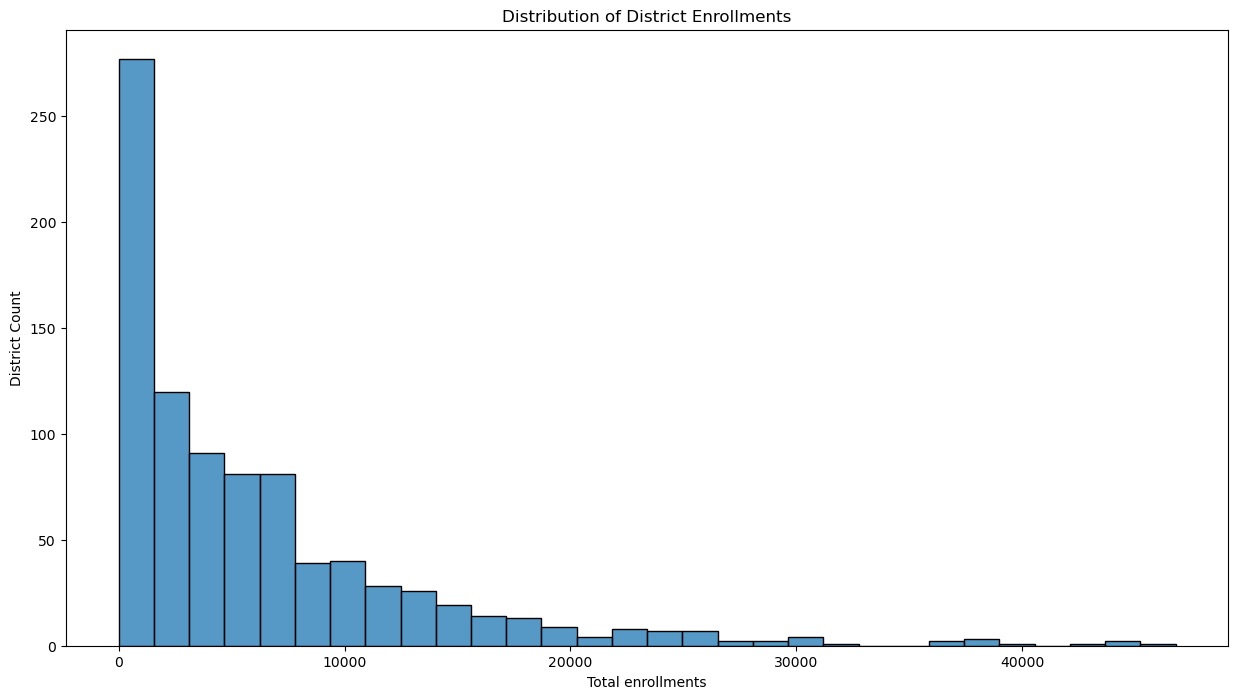

In [50]:
plt.figure(figsize=(15,8))
sns.histplot(data=district_total,x='total_enrollments', bins=30)
plt.title('Distribution of District Enrollments')
plt.xlabel('Total enrollments')
plt.ylabel('District Count')
plt.show()

#### Insight: 
The distribution of total Aadhaar enrolments across districts is highly right-skewed.
A majority of districts fall within the lower enrollment range (below 10,000), while a small number of districts exhibit substantially higher enrolment volumes, forming a long right tail

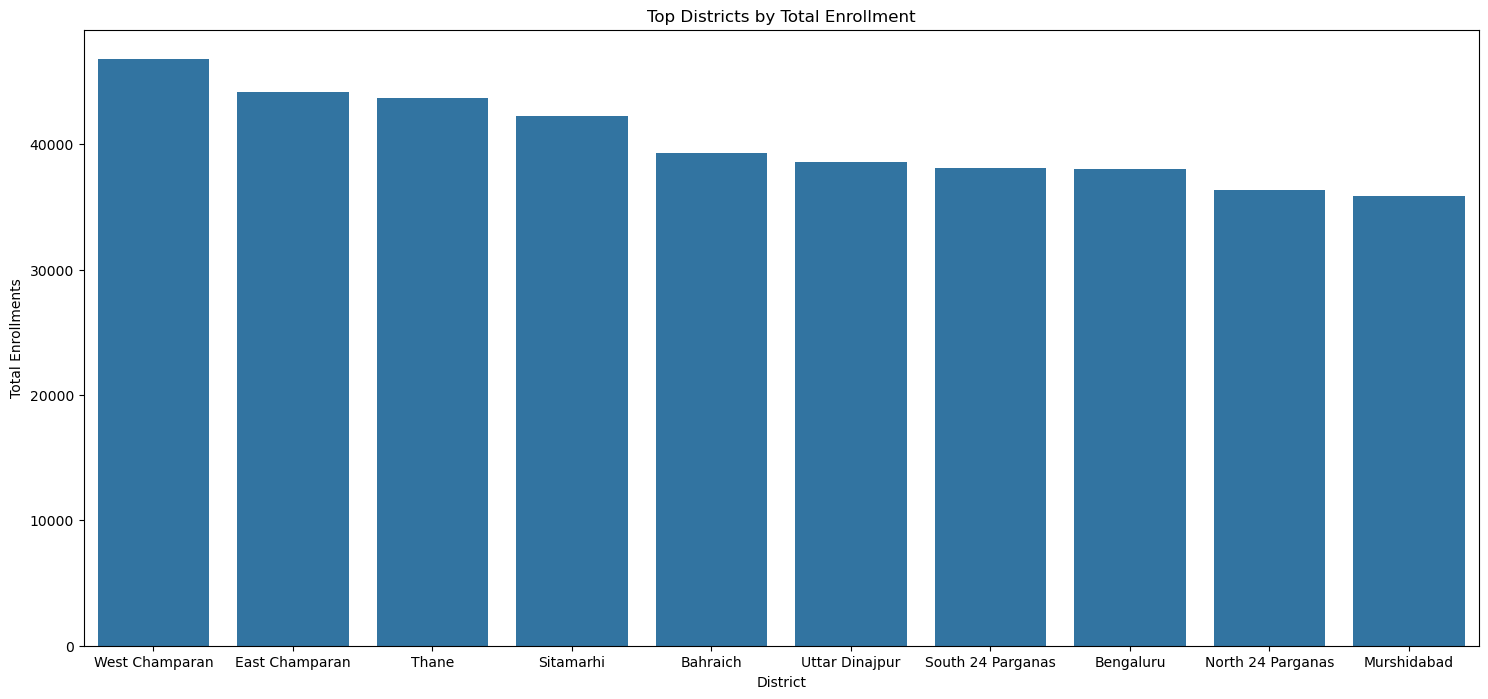

In [51]:
plt.figure(figsize=(18,8))
sns.barplot(data=top_10_districts,x='district', y='total_enrollments')
plt.title('Top Districts by Total Enrollment')
plt.xlabel('District')
plt.ylabel('Total Enrollments')
plt.show()

#### Insight:
The top districts exhibit a clear concentration of enrollment activity.
A small subset of districts exceeds 40,000 total enrolments, while the remaining top districts show a gradual decline, reinforcing the right skewed distribution observed earlier. This indicates that Aadhaar enrollment volumes are dominated by a limited number of high activity districts rather than being evenly distributed.

### II. District-level Monthly Analysis

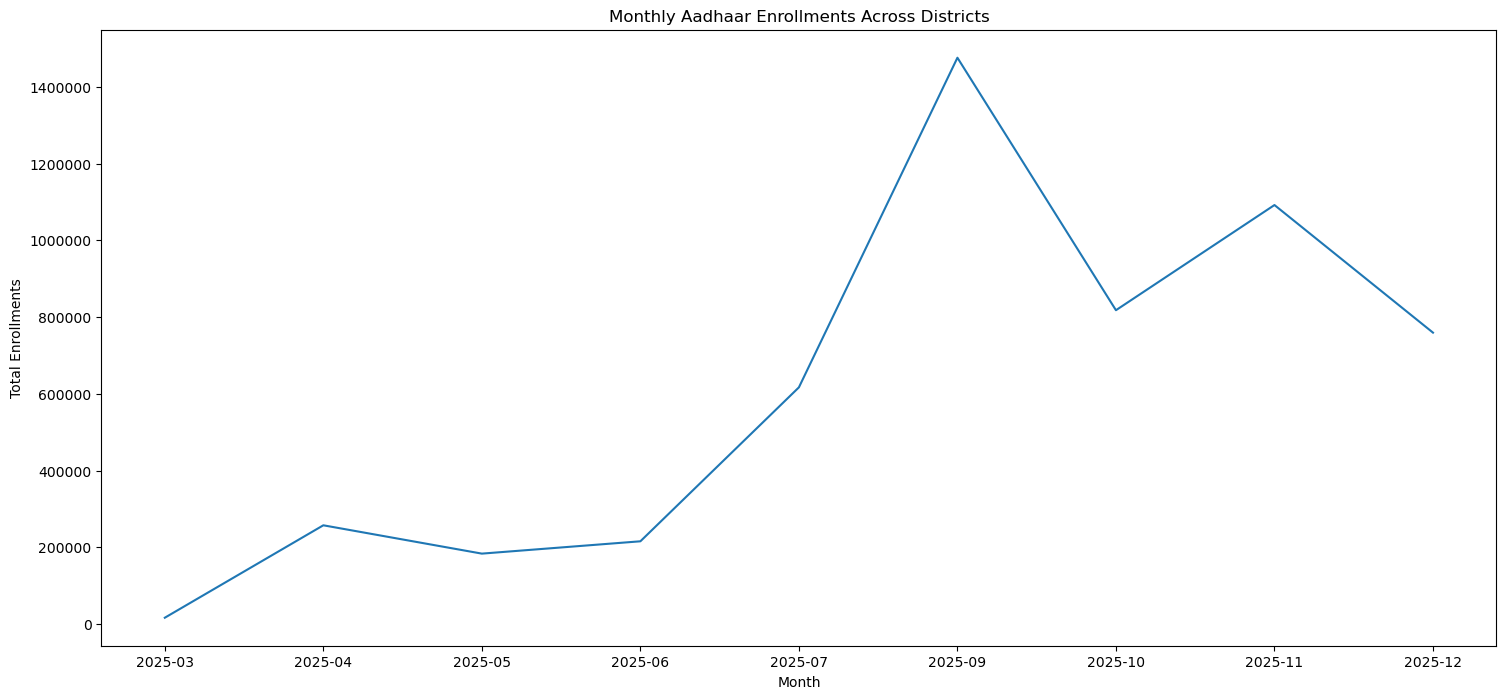

In [52]:
monthly_total = (
    district_month
    .groupby('month', as_index=False)['total_enrollments']
    .sum()
    .sort_values('month')
)

monthly_total['month'] = monthly_total['month'].astype(str)

plt.figure(figsize=(18, 8))
sns.lineplot(data=monthly_total, x='month', y='total_enrollments')
plt.title('Monthly Aadhaar Enrollments Across Districts')
plt.xlabel('Month')
plt.ylabel('Total Enrollments')
plt.ticklabel_format(style='plain', axis='y')
plt.show()


#### Insight:
Aadhaar enrolments show a gradual increase from March to April, followed by a dip in May and modest recovery in June. A sharp increase is observed between July and September, with September recording the highest enrolment volume. Notably, August data is absent in the dataset, indicating a reporting gap rather than a decline. Enrollments fall in October, rise again in November, and decline in December.

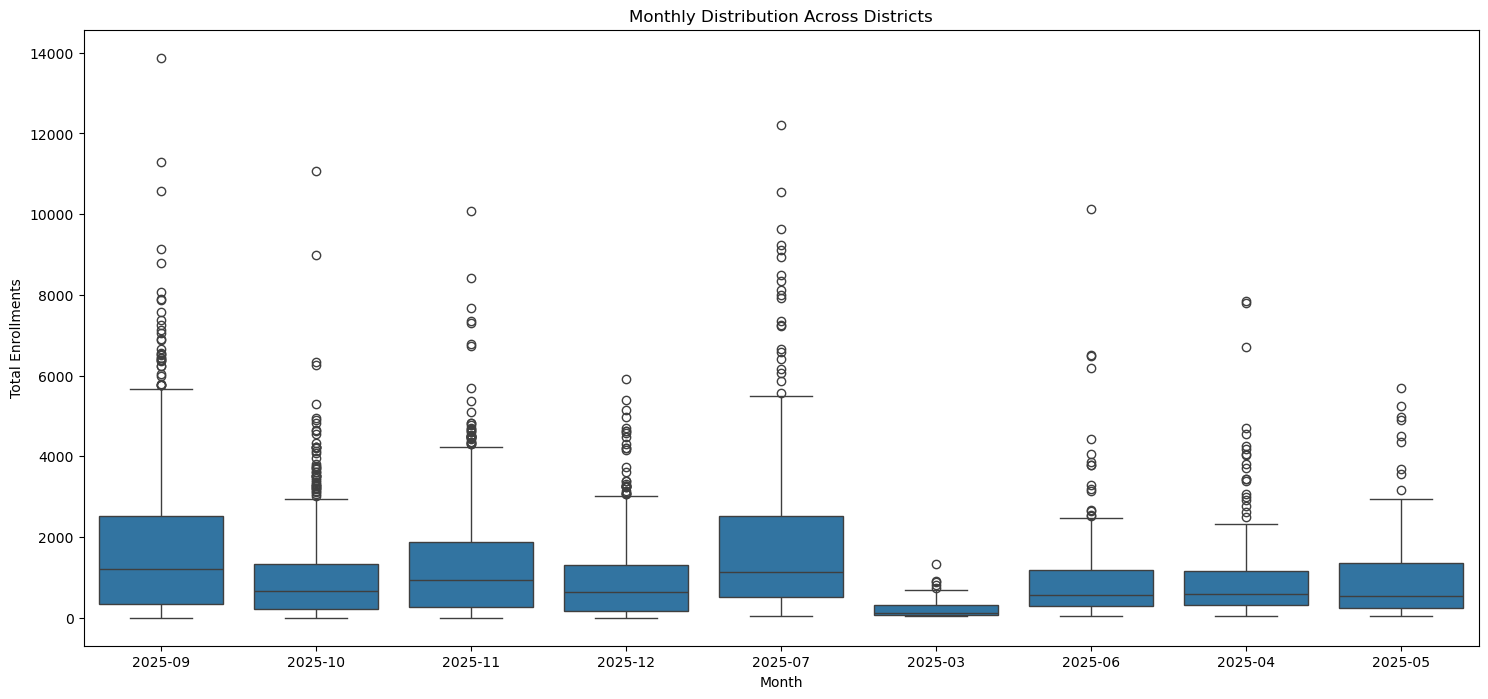

In [53]:
plt.figure(figsize=(18,8))
sns.boxplot(data=district_month,x='month',y='total_enrollments')
plt.title('Monthly Distribution Across Districts')
plt.xlabel('Month')
plt.ylabel('Total Enrollments')
plt.show()

#### Insight:
District-level enrolments exhibit substantial variation within each month, with most districts recording relatively low to moderate enrolment volumes while a small number of districts contribute disproportionately high counts. September shows the widest spread and highest upper outliers, indicating peak enrolment intensity across districts. March displays the lowest overall distribution, reflecting minimal enrolment activity during the early phase of the period.

### III. State level Analysis

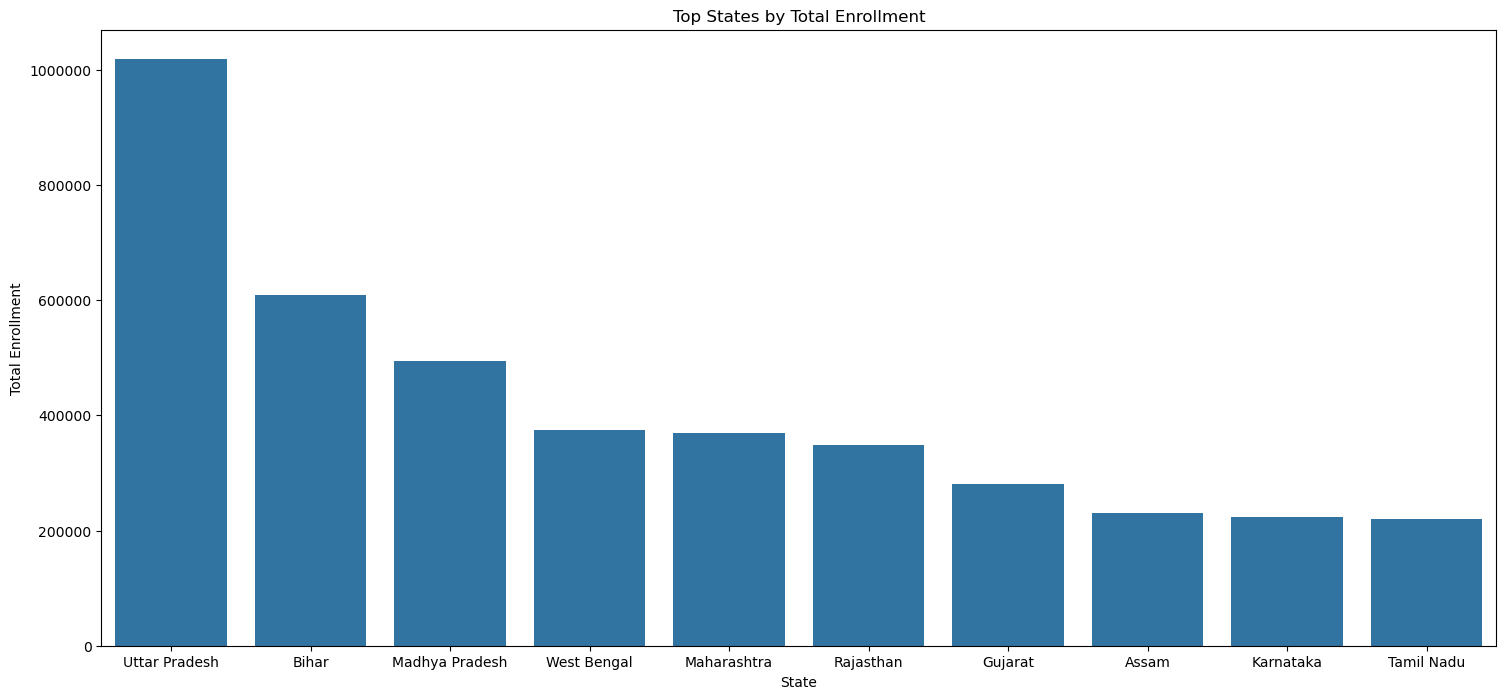

In [54]:
plt.figure(figsize=(18,8))
sns.barplot(data=top_10_state,x='state',y='total_enrollments')
plt.title('Top States by Total Enrollment')
plt.xlabel('State')
plt.ylabel('Total Enrollment')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

#### Insight:
Uttar Pradesh records the highest Aadhaar enrolment volume, exceeding one million enrollments during the observed period. A sharp drop is observed beyond the top state, with all remaining states in the top ten registering below six hundred thousand enrollments, indicating a strong concentration of enrollment activity in a single state.

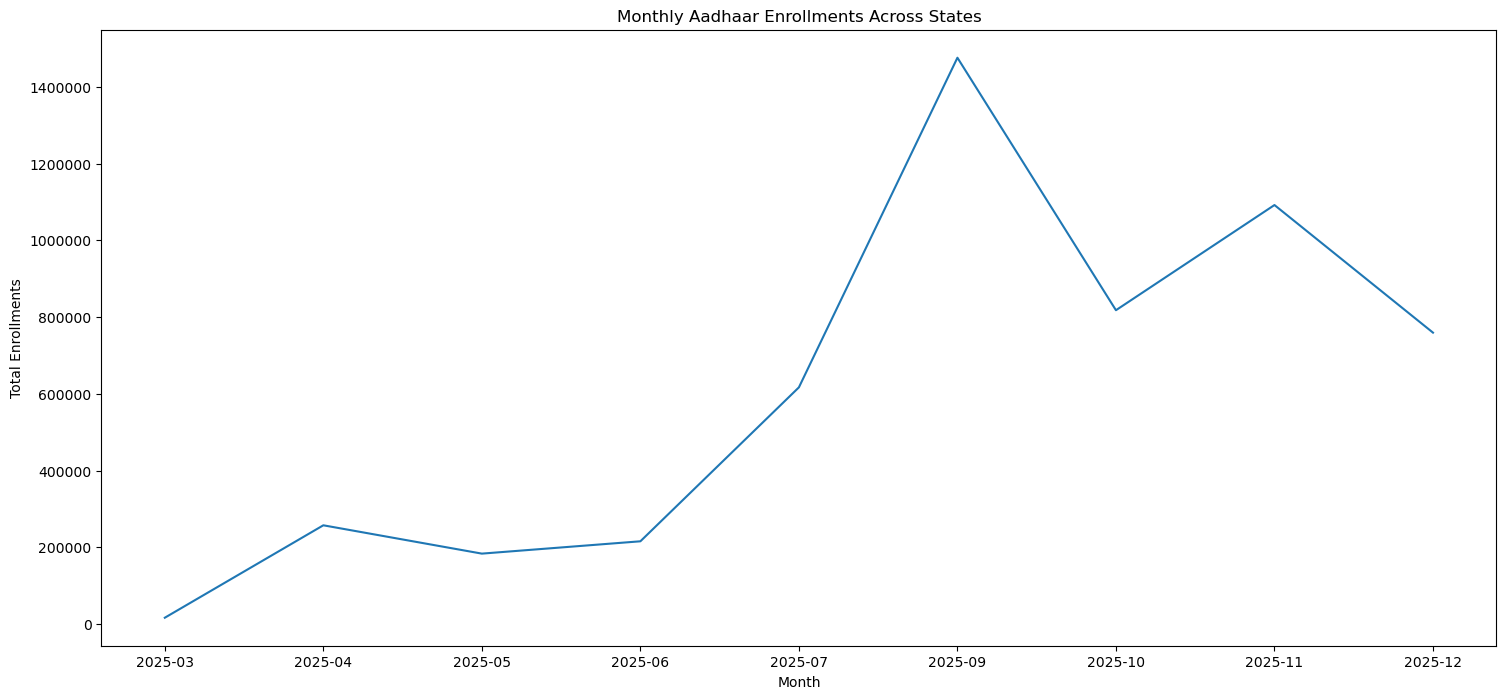

In [55]:
monthly_total_state = (
    state_month
    .groupby('month', as_index=False)['total_enrollments']
    .sum()
    .sort_values('month')
)

monthly_total_state['month'] = monthly_total_state['month'].astype(str)

plt.figure(figsize=(18, 8))
sns.lineplot(data=monthly_total_state, x='month', y='total_enrollments')
plt.title('Monthly Aadhaar Enrollments Across States')
plt.xlabel('Month')
plt.ylabel('Total Enrollments')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

#### Insight:
State level enrollments exhibit clear temporal variation across the observed months, with a pronounced rise during the mid-to-late period followed by a decline toward the end of the year. The overall pattern mirrors the district level monthly trend, indicating that aggregate enrolment dynamics are driven by broad, system wide factors rather than isolated regional effects.

### Note:
The univariate analysis examined Aadhaar enrollment patterns independently across districts, states, and time. District-level analysis revealed a highly right-skewed distribution, with enrollment activity concentrated in a small number of districts. Monthly analysis showed clear temporal variation, including a pronounced mid-period peak and an explicit data gap for August, indicating reporting absence rather than zero activity. State-level analysis further highlighted strong concentration, with a few states contributing a disproportionately large share of total enrollments. Overall, univariate findings establish that Aadhaar enrollment is unevenly distributed across geography and time.

## Bivariate Analysis

### I. District level analysis

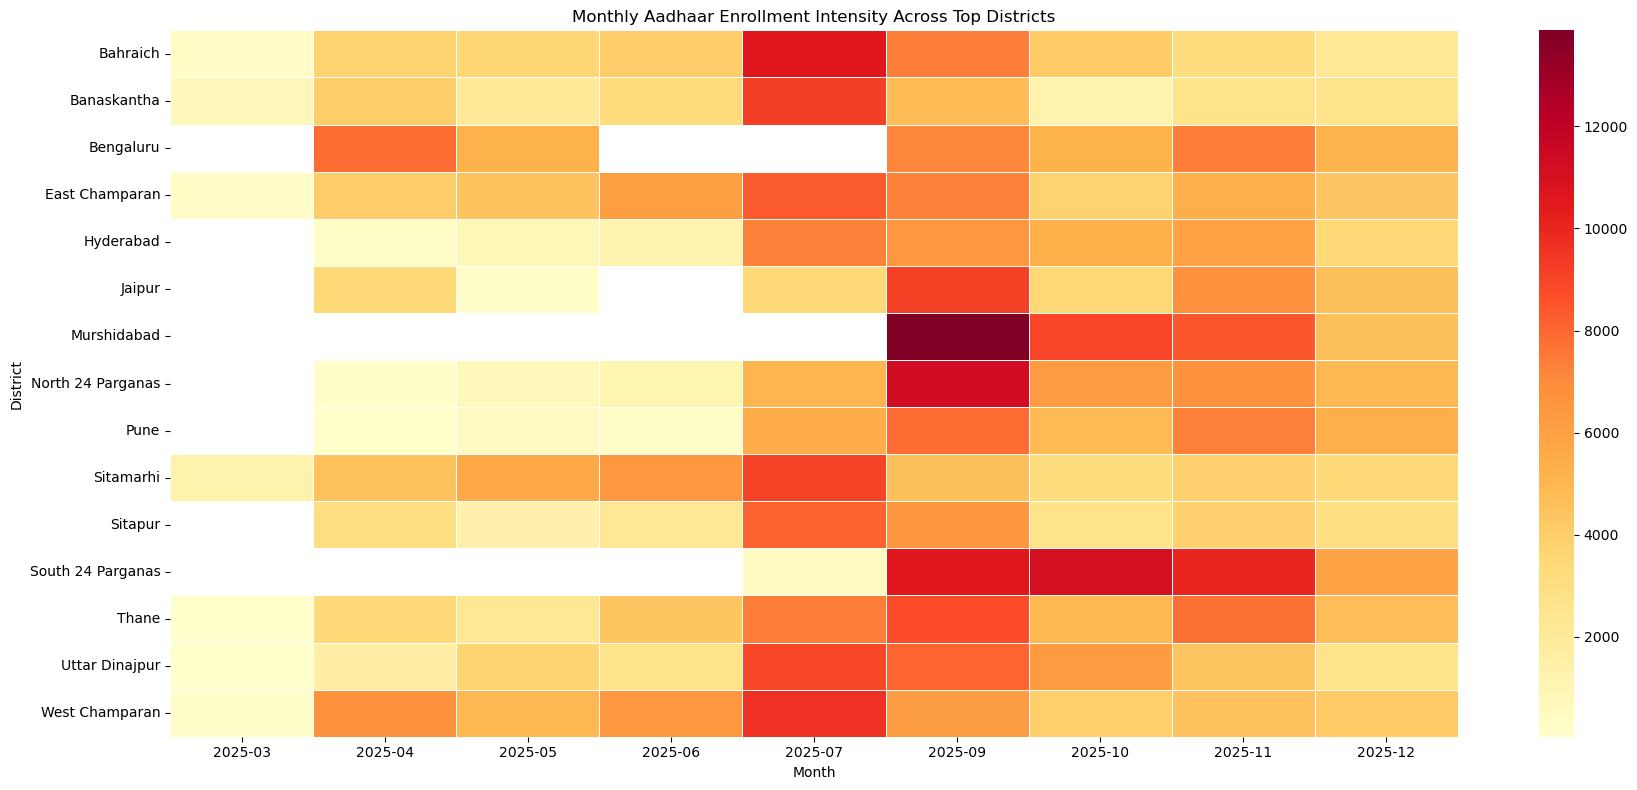

In [56]:
top_districts = (
    district_month
    .groupby('district', as_index=False)['total_enrollments']
    .sum()
    .sort_values(by='total_enrollments', ascending=False)
    .head(15)['district']
)


heatmap_data = (
    district_month[district_month['district'].isin(top_districts)]
    .groupby(['district', 'month'], as_index=False)['total_enrollments']
    .sum()
    .pivot(index='district', columns='month', values='total_enrollments')
)


plt.figure(figsize=(18, 8))
sns.heatmap(
    heatmap_data,
    cmap='YlOrRd',
    linewidths=0.5
)
plt.title('Monthly Aadhaar Enrollment Intensity Across Top Districts')
plt.xlabel('Month')
plt.ylabel('District')
plt.tight_layout()
plt.show()


#### Insight:
The heatmap reveals pronounced month–district interaction effects. Murshidabad and South 24 Parganas exhibit sharp increases in enrollment during specific months, indicating strong temporal concentration rather than steady activity. In contrast, Thane shows relatively consistent enrollment intensity across months, suggesting a more stable and evenly distributed enrollment pattern over time

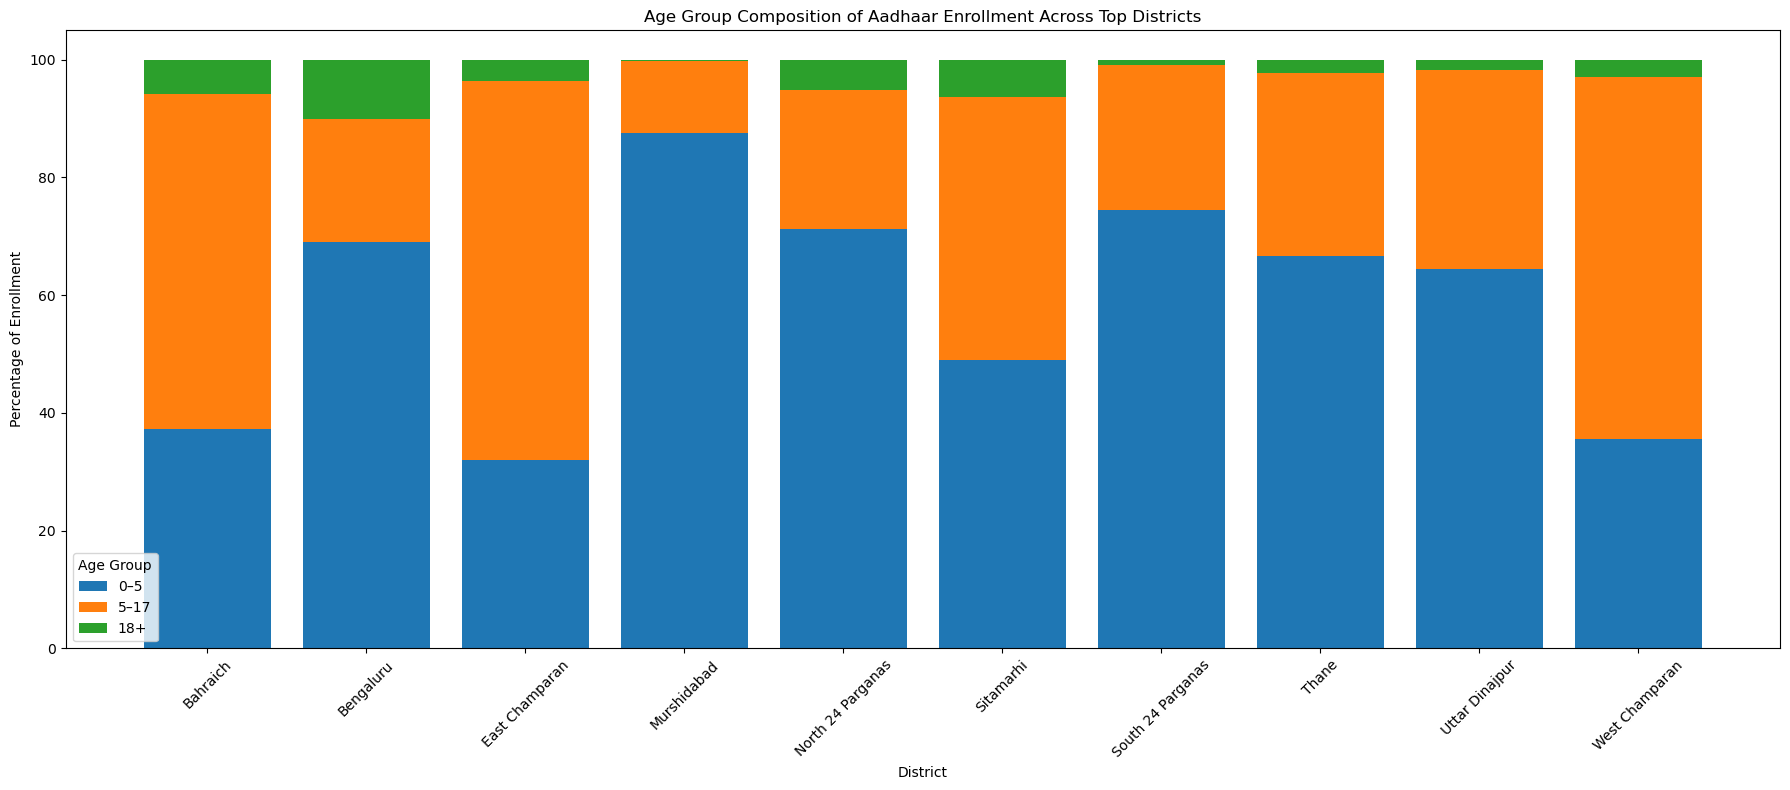

In [ ]:
plt.figure(figsize=(18, 8))

plt.bar(district_age['district'], district_age['0-5 %'], label='0-5')
plt.bar(
    district_age['district'],
    district_age['5-17 %'],
    bottom=district_age['0-5 %'],
    label='5-17'
)
plt.bar(
    district_age['district'],
    district_age['18+ %'],
    bottom=district_age['0-5 %'] + district_age['5-17 %'],
    label='18+'
)

plt.title('Age Group Composition of Aadhaar Enrollment Across Top Districts')
plt.xlabel('District')
plt.ylabel('Percentage of Enrollment')
plt.xticks(rotation=45)
plt.legend(title='Age Group')
plt.tight_layout()
plt.show()


#### Insight:
The age composition of Aadhaar enrollment varies noticeably across districts. Several high-enrollment districts show a disproportionately large share of enrollments in the 0–5 age group, while the 18+ age group consistently represents the smallest share across districts. This indicates that enrollment activity in these districts is more concentrated among younger age cohorts rather than adult populations.
The relative balance between the 0–5 and 5–17 age groups differs by district, suggesting heterogeneous enrollment composition even among top-enrollment districts.


### II. State level analysis

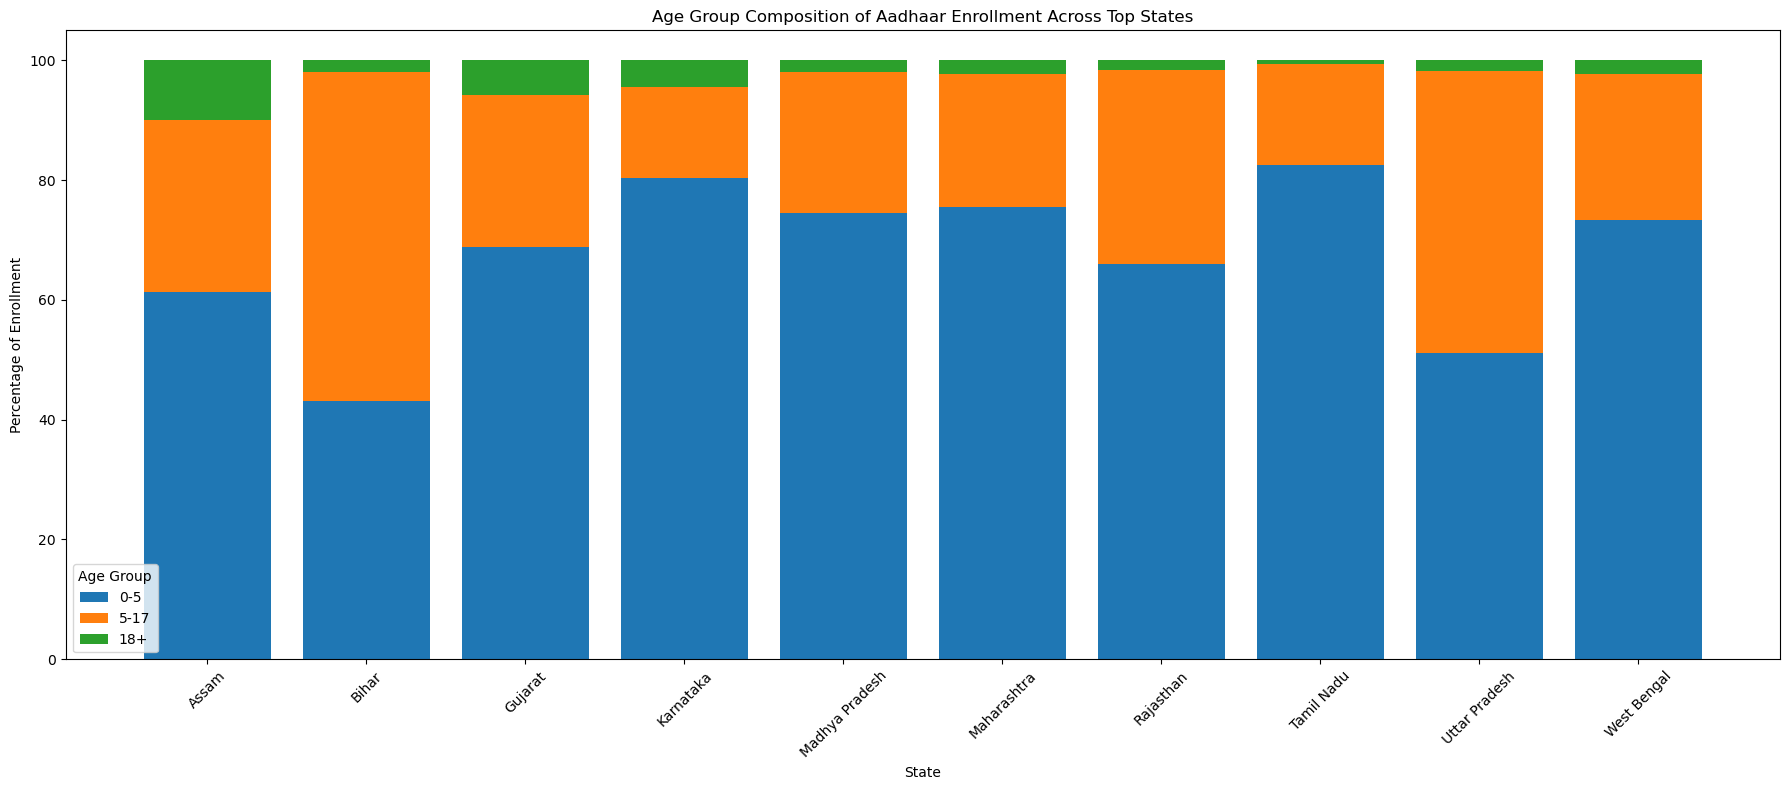

In [70]:
plt.figure(figsize=(18, 8))

plt.bar(state_age['state'], state_age['0-5 %'], label='0-5')
plt.bar(
    state_age['state'],
    state_age['5-17 %'],
    bottom=state_age['0-5 %'],
    label='5-17'
)
plt.bar(
    state_age['state'],
    state_age['18+ %'],
    bottom=state_age['0-5 %'] + state_age['5-17 %'],
    label='18+'
)

plt.title('Age Group Composition of Aadhaar Enrollment Across Top States')
plt.xlabel('State')
plt.ylabel('Percentage of Enrollment')
plt.xticks(rotation=45)
plt.legend(title='Age Group')
plt.tight_layout()
plt.show()


#### Insight:
Across top-enrollment states, Aadhaar enrollment is predominantly driven by younger age groups, with the 0-5 and 5-17 cohorts accounting for the majority share. The 18+ age group consistently represents the smallest proportion across states, although the relative balance between child and youth enrollments varies by state, indicating differences in enrollment composition at the state level

### Note:
The bivariate analysis explored relationships between enrollment and key dimensions such as time, geography, and age groups. District–month analysis revealed significant variation in enrollment intensity over time, with some districts exhibiting sharp temporal peaks while others maintained relatively stable patterns. District–age group analysis showed substantial differences in enrollment composition, with younger age groups (0–5 and 5–17) accounting for the majority share across high-enrollment districts, though the balance varied by location. State-level age composition mirrored these patterns at an aggregate level, reinforcing that enrollment dynamics differ not only in scale but also in demographic structure across regions.